In [84]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F  # Para GELU si no usas nn.GELU directamente
from torch_optimizer import RAdam


# Datos

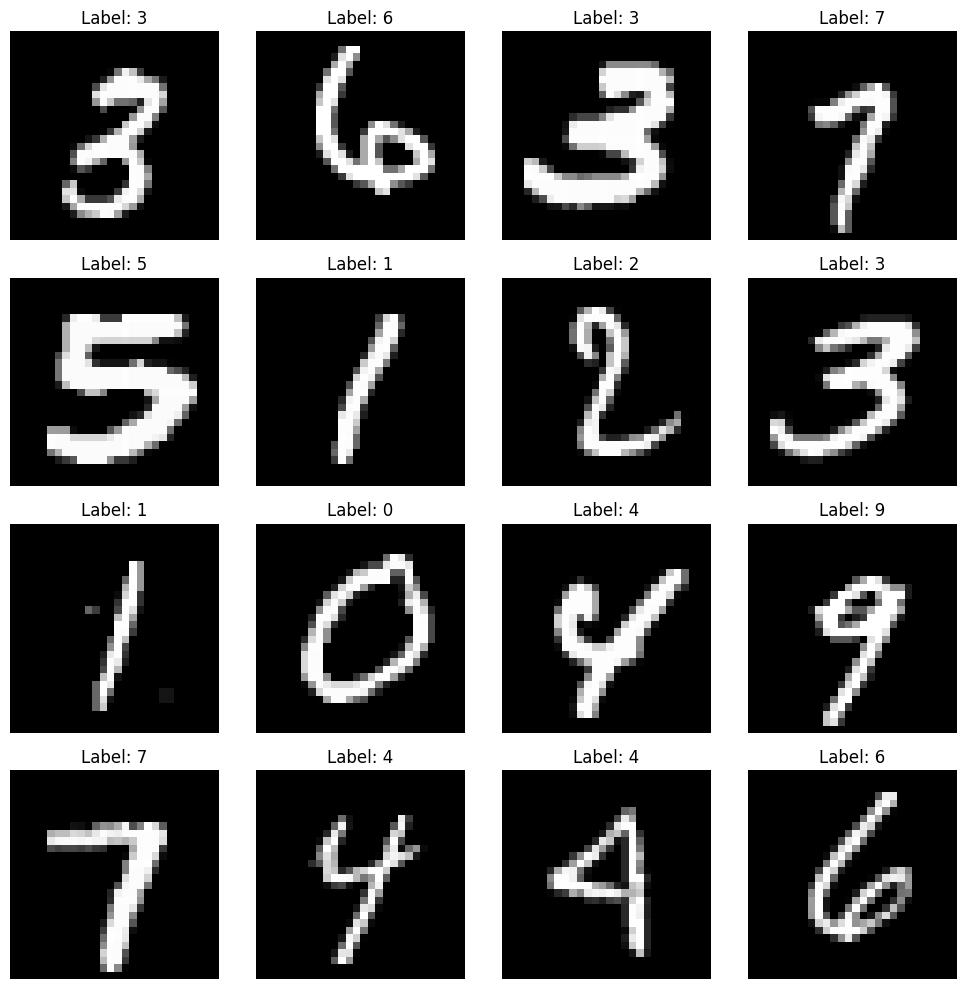

In [85]:

# Load MNIST dataset
# Definimos una secuencia de transformaciones para aplicar a las imágenes del dataset.
# En este caso, solo convertimos las imágenes a tensores utilizando `ToTensor()`.
# Esto es necesario para que las imágenes estén en un formato compatible con PyTorch.
transform = transforms.Compose([
    transforms.ToTensor()  # Convierte la imagen de un formato PIL o numpy.ndarray a un tensor.
])

# Cargamos el dataset MNIST de entrenamiento.
# `root='./data'` especifica el directorio donde se descargarán los datos si no están presentes.
# `train=True` indica que queremos el conjunto de datos de entrenamiento.
# `transform=transform` aplica las transformaciones definidas previamente a cada imagen.
# `download=True` descarga los datos si no están disponibles en el directorio especificado.
mnist_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)

# Creamos un DataLoader que nos permite cargar los datos en lotes pequeños.
# `dataset=mnist_dataset` es el dataset que se cargará.
# `batch_size=16` indica que cada lote contendrá 16 imágenes y etiquetas.
# `shuffle=True` mezcla los datos aleatoriamente en cada época, mejorando la generalización del modelo.
data_loader = DataLoader(
    mnist_dataset, batch_size=16, shuffle=True
)

# Obtenemos un único lote de datos del DataLoader.
# `next(iter(data_loader))` convierte el DataLoader en un iterador y toma el primer lote.
# El lote contiene `images` (los tensores de las imágenes) y `labels` (las etiquetas correspondientes).
images, labels = next(iter(data_loader))


# Plot the images in a grid
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Arquitectura

In [86]:

# Definimos el modelo MLP
# MLP hereda de nn.Module, lo que permite utilizar las funciones y propiedades de PyTorch
# para crear, entrenar y evaluar redes neuronales.
class MLP(nn.Module):
    def __init__(self):
        # Inicializamos la clase base nn.Module
        # Esto habilita funciones esenciales como la gestión de capas y forward pass.
        super(MLP, self).__init__()
        # Capa completamente conectada: de entrada (28x28 píxeles) a 512 neuronas
        self.fc1 = nn.Linear(28 * 28, 1024)
        # Capa oculta: de 512 neuronas a 256 neuronas
        self.fc2 = nn.Linear(1024, 512)
        #Capa oculta: de 512 neuronas a 256 neuronas
        self.fc3 = nn.Linear(512, 10)
        
        #self.fc4 = nn.Linear(10, 10)
        # Función de activación ReLU
        self.relu = nn.ReLU()
        # Dropout para evitar sobreajuste
        self.dropout = nn.Dropout(0.2)

    # Definimos cómo pasa la información a través de la red
    # Este método es obligatorio en las clases que heredan de nn.Module.
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplanamos las imágenes (de 28x28 a 1D)
        x = self.relu(self.fc1(x))  # Aplicamos la primera capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.relu(self.fc2(x))  # Aplicamos la segunda capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.fc3(x)             # Aplicamos la capa de salida
        return x
    
#segunda opcion

#    def forward(self, x):
#        x = x.view(-1, 28 * 28)  # Aplanamos las imágenes (de 28x28 a 1D)
#        x = F.gelu(self.fc1(x))  # Aplicamos la primera capa y GELU
#        x = self.dropout(x)      # Aplicamos Dropout
#        x = F.gelu(self.fc2(x))  # Aplicamos la segunda capa y GELU
#        x = self.dropout(x)      # Aplicamos Dropout
#        x = self.fc3(x)          # Aplicamos la capa de salida
#        return x


# Entrenamiento

In [87]:
# Hiperparámetros
#batch_size = 32       # Tamaño de lote 2
batch_size = 64       # Tamaño de lote
learning_rate = 0.001 # Tasa de aprendizaje
#learning_rate = 0.01 # Tasa de aprendizaje 2
epochs = 10           # Número de épocas de entrenamiento
#epochs = 15           # Número de épocas de entrenamiento 2

# Preprocesamiento y carga de datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertimos imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)  # Dataset de prueba
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Dataloader para entrenamiento
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Dataloader para prueba

# Definimos el modelo, la función de pérdida y el optimizador
model = MLP()                             # Creamos una instancia del modelo MLP
criterion = nn.CrossEntropyLoss()         # Función de pérdida para clasificación
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizador Adam
#optimizer = RAdam(model.parameters(), lr=learning_rate)  #optimizador RAdam

# Bucle de entrenamiento
for epoch in range(epochs):
    model.train()  # Ponemos el modelo en modo entrenamiento
    for images, labels in train_loader:  # Iteramos sobre lotes de datos
        optimizer.zero_grad()            # Reiniciamos los gradientes
        outputs = model(images)          # Hacemos una predicción con el modelo
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()                  # Propagamos los gradientes
        optimizer.step()                 # Actualizamos los pesos del modelo

    # Mostramos la pérdida al final de cada época
    print(f"Época [{epoch+1}/{epochs}], Pérdida: {loss.item():.4f}")



Época [1/10], Pérdida: 0.1467
Época [2/10], Pérdida: 0.0387
Época [3/10], Pérdida: 0.0815
Época [4/10], Pérdida: 0.0255
Época [5/10], Pérdida: 0.0206
Época [6/10], Pérdida: 0.0974
Época [7/10], Pérdida: 0.0116
Época [8/10], Pérdida: 0.0510
Época [9/10], Pérdida: 0.0580
Época [10/10], Pérdida: 0.2291


# Evaluación del modelo

In [88]:
model.eval()  # Ponemos el modelo en modo evaluación (desactiva Dropout)
correct = 0
total = 0
with torch.no_grad():  # Desactivamos el cálculo de gradientes para evaluación
    for images, labels in test_loader:  # Iteramos sobre los datos de prueba
        outputs = model(images)         # Hacemos predicciones
        _, predicted = torch.max(outputs.data, 1)  # Obtenemos la clase con mayor probabilidad
        total += labels.size(0)         # Total de muestras evaluadas
        correct += (predicted == labels).sum().item()  # Contamos las predicciones correctas

# Calculamos y mostramos la precisión del modelo
accuracy = 100 * correct / total
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}%")

Accuracy en el conjunto de prueba: 97.68%


In [89]:
# Verificar si hay una GPU disponible, de lo contrario usar la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocesamiento: Definir transformaciones para los datos
transform = transforms.Compose([
    transforms.ToTensor(),                # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar los valores a un rango de [-1, 1]
])

# Cargar el conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)  # Datos de entrenamiento
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)  # Datos de prueba

# Crear DataLoaders para manejar los datos de forma eficiente
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # Loader para entrenamiento (batch de 128, mezclado)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    # Loader para prueba (batch de 128, sin mezclar)

class CNN(nn.Module):
    #def __init__(self, verbose=False, filters_l1=32, filters_l2=64, dropout=0.2, final_layer_size=128):
    def __init__(self, verbose=False, filters_l1=32, filters_l2=64, dropout=0.2, final_layer_size=64):    
    #def __init__(self, verbose=False, filters_l1=64, filters_l2=128, dropout=0.2, final_layer_size=128):    
        super(CNN, self).__init__()
        self.verbose = verbose
        self.filters_l1 = filters_l1
        self.filters_l2 = filters_l2
        self.dropout_rate = dropout
        self.final_layer_size = final_layer_size

        # Primera capa convolucional
        self.conv1 = nn.Conv2d(1, self.filters_l1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(self.filters_l1, self.filters_l2, kernel_size=3, stride=1, padding=1)

        # Calcular automáticamente las dimensiones de la capa lineal (fc1)
        self.fc1_input_size = self._calculate_fc1_input_size()
        
        # Primera capa completamente conectada
        self.fc1 = nn.Linear(self.fc1_input_size, self.final_layer_size)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.final_layer_size, 10)  # Capa de salida para 10 clases (MNIST)


    def _calculate_fc1_input_size(self):
        """
        Calcula automáticamente el tamaño de la entrada para la primera capa completamente conectada (fc1).
        Simula una pasada con una imagen de prueba de tamaño (1, 28, 28).
        """
        with torch.no_grad():  # Desactiva gradientes
            x = torch.randn(1, 1, 28, 28)  # Tensor ficticio de entrada con tamaño MNIST (batch_size=1)
            x = self.pool(torch.relu(self.conv1(x)))  # Aplicar Conv1 -> Pool
            x = self.pool(torch.relu(self.conv2(x)))  # Aplicar Conv2 -> Pool
            fc1_input_size = x.numel()  # Calcular número total de elementos
        return fc1_input_size

    def forward(self, x):
        if self.verbose: 
            print(f"Entrada: {x.shape}")  # Imprime la dimensión de la entrada

        # Primera capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv1(x)))
        if self.verbose:
            print(f"Después de Conv1 y MaxPooling: {x.shape}")  # Dimensión después de Conv1 y Pool

        # Segunda capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv2(x)))
        if self.verbose:
            print(f"Después de Conv2 y MaxPooling: {x.shape}")  # Dimensión después de Conv2 y Pool

        # Aplanar las características 2D a 1D
        x = x.view(-1, self.fc1_input_size)
        if self.verbose:
            print(f"Después de Aplanamiento: {x.shape}")  # Dimensión después de Flatten

        # Primera capa completamente conectada
        x = torch.relu(self.fc1(x))
        if self.verbose:
            print(f"Después de Fully Connected (fc1): {x.shape}")  # Dimensión después de fc1

        # Aplicar Dropout
        x = self.dropout(x)
        if self.verbose:
            print(f"Después de Dropout: {x.shape}")  # Dimensión después de Dropout

        # Capa de salida
        x = self.fc2(x)
        if self.verbose:
            print(f"Después de Fully Connected (fc2): {x.shape}")  # Dimensión después de fc2 (salida final)

        return x



In [90]:
# Inicializar el modelo, la función de pérdida y el optimizador
model = CNN(verbose=False, filters_l1=8, filters_l2=32, dropout=0.2, final_layer_size=128).to(device)                             # Mover el modelo a la GPU/CPU
criterion = nn.CrossEntropyLoss()                    # Función de pérdida para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizador Adam con tasa de aprendizaje 0.001

# Definir la función de entrenamiento
def train(model, loader, criterion, optimizer, device):
    model.train()  # Establecer el modelo en modo de entrenamiento
    running_loss = 0.0
    for images, labels in loader:  # Iterar sobre los lotes de datos
        images, labels = images.to(device), labels.to(device)  # Mover los datos a la GPU/CPU

        optimizer.zero_grad()       # Reiniciar los gradientes
        outputs = model(images)     # Paso hacia adelante
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()             # Paso hacia atrás (cálculo de gradientes)
        optimizer.step()            # Actualizar los pesos

        running_loss += loss.item()  # Acumular la pérdida
    return running_loss / len(loader)  # Devolver la pérdida promedio

# Definir la función de evaluación
def evaluate(model, loader, device):
    model.eval()  # Establecer el modelo en modo de evaluación
    correct = 0
    total = 0
    with torch.no_grad():  # Deshabilitar el cálculo de gradientes para ahorrar memoria
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos a la GPU/CPU
            outputs = model(images)  # Paso hacia adelante
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones (clase con mayor probabilidad)
            total += labels.size(0)  # Contar el número total de ejemplos
            correct += (predicted == labels).sum().item()  # Contar las predicciones correctas
    return correct / total  # Calcular la precisión

# Bucle principal de entrenamiento
num_epochs = 10  # Número de épocas
for epoch in range(num_epochs):
    # Entrenar el modelo y calcular la pérdida
    train_loss = train(model, train_loader, criterion, optimizer, device)
    # Evaluar el modelo en el conjunto de prueba
    test_accuracy = evaluate(model, test_loader, device)
    # Imprimir los resultados de la época actual
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calcular la precisión final en el conjunto de prueba
final_accuracy = evaluate(model, test_loader, device)
print(f"Final Test Accuracy: {final_accuracy:.4f}")


Epoch [1/10], Loss: 0.3440, Test Accuracy: 0.9750
Epoch [2/10], Loss: 0.0882, Test Accuracy: 0.9829
Epoch [3/10], Loss: 0.0619, Test Accuracy: 0.9864
Epoch [4/10], Loss: 0.0508, Test Accuracy: 0.9891
Epoch [5/10], Loss: 0.0412, Test Accuracy: 0.9873
Epoch [6/10], Loss: 0.0361, Test Accuracy: 0.9874
Epoch [7/10], Loss: 0.0311, Test Accuracy: 0.9890
Epoch [8/10], Loss: 0.0260, Test Accuracy: 0.9908
Epoch [9/10], Loss: 0.0242, Test Accuracy: 0.9910
Epoch [10/10], Loss: 0.0208, Test Accuracy: 0.9899
Final Test Accuracy: 0.9899


-ORIGINAL
Accuracy en el conjunto de prueba: 97.53%
Final Test Accuracy: 0.9895


2.1.1 Modificaciones de la arquitectura
- el numero de neuronas por capa
Se aumenta al doble el numero de neuronas por capa
Accuracy en el conjunto de prueba: 97.87%
Final Test Accuracy: 0.9905

el mejor resultado se puede deber a que el modelo tiene mayor capacidad para aprender 
patrones complejos en los datos, sin embargo, la mejora es pequeña esto quiere decir
que los datos originales ya estaban cerca de su mejor rendimiento 

- la cantidad de capas ocultas
se aumenta 1 capa
Accuracy en el conjunto de prueba: 97.64%
Final Test Accuracy: 0.9906

Existe una ligera disminución del accuracy en el conjunto de prueba que se puede explicar
porque al agregar más capaz se pueden estar generando rebundancias, es decir, el modelo
no encuentra caracteristicas nuevas que aprender generando que el modelo pierda en poca
medida la capacidad de generalizar 

- tipo de funcion de activacion utilizada.
La función de activación la pase de ReLu a GELU
Accuracy en el conjunto de prueba: 97.67%
Final Test Accuracy: 0.9902

Las diferencias observadas se puedes deber a la naturalez de ambas funciones, en redes
más simples ReLu tiene ventajas al ser menos compleja, más rápida y suficientemente eficaz.
Se adapta mejor a datasets simples y poco profundas.

2.1.2 Modificaciones del entrenamiento
- el algoritmo de optimizacion
Se utiliza el Radam
Accuracy en el conjunto de prueba: 97.66%
Final Test Accuracy: 0.9898 
El cambio en el algoritmo de optimización genero desminuciones en la precisión, esto se puede
explicar RAdam puede deberse a que no alcanza un óptimo global tan bueno dentro del número de 
épocas configurado, por otro lado, RAdam puede ser más útil en problemas más complejos o arquitecturas profundas.

- la tasa de aprendizaje (learning rate)
learning_rate = 0.01 # Tasa de aprendizaje
Accuracy en el conjunto de prueba: 89.71%
Final Test Accuracy: 0.9905

El cambio en la tasa de aprendizaje desde 0.001 a 0.01 genero una disminucion importante
de la presición en el conjunto de prueba, esto se puede explicar porque una tasa de
aprendizaje alta puede generar que el modelo oscile alrededor del óptimo y generando 
problemas de generalización. 

- el tamano del lote (batch size) 
pasar de 64 original a 32
Accuracy en el conjunto de prueba: 97.63%
Final Test Accuracy: 0.9907

- el numero de epocas.
Se sube el numero de epocas desde 10 a 15.
Accuracy en el conjunto de prueba: 97.62%
Final Test Accuracy: 0.9904
Al aumentar el número de épocas, el modelo tiene más tiempo para ajustarse a los datos 
de entrenamiento.Esto puede llevar a un sobreajuste, donde el modelo aprende patrones 
específicos del conjunto de entrenamiento que no generalizan bien al conjunto de prueba.



2.2 Redes convolucionales
2.2.1 Modificaciones de la arquitectura
- el numero de filtros
filters_l1=64, filters_l2=128
aumente al doble el numero de filtros y tuve los siguientes resultados:
Accuracy en el conjunto de prueba: 97.32%
Final Test Accuracy: 0.9914
Incrementar el número de filtros en las capas convolucionales permite que el modelo 
aprenda más características por capa.Esto incrementa la capacidad del modelo para 
captar detalles más complejos y específicos en los datos de entrada.
La mejora en la Final Test Accuracy (0.9905 a 0.9914) sugiere que el modelo pudo 
capturar patrones más relevantes, lo que mejora la generalización en el conjunto 
de prueba final.

- el numero de neuronas en la capa posterior a las capas convolucionales
pasa de 128 a 64
Accuracy en el conjunto de prueba: 97.68%
Final Test Accuracy: 0.9899
hay ligeras modifaciones en la precisión al reducir el número de neuronas de 128 a 64, 
disminuyes la capacidad del modelo para capturar y combinar características complejas.

- agregando más capas lineales y el parámetro asociado a dropout.
agregar dos capas adicionales con 256 y 128 neuronas respectivamente
Accuracy en el conjunto de prueba: 97.82%



2.3 Comparacion
Perceptrón Multicapa:

La mejor configuración fue con 2 capas ocultas (200 y 256 neuronas), función de activación ReLU, logrando un buen equilibrio entre precisión (97.67%) y eficiencia.
Cambios adicionales como agregar una capa, cambiar la función de activación o el optimizador no ofrecieron mejoras significativas y, en algunos casos, redujeron la generalización.

Redes Convolucionales:

La configuración óptima fue con filtros (64, 128), 128 neuronas después de las capas convolucionales, y dropout de 0.2, logrando un buen balance entre capacidad de procesamiento y eficiencia computacional.
Aumentar los filtros mejoró la precisión final (0.9914), pero afectó la precisión en el conjunto de prueba (97.32%).
Cambios extremos como aumentar el dropout o reducir neuronas perjudicaron la precisión.
